In [1]:
!pip install -q easysnowdata # new comment

In [2]:
import pandas as pd
import geopandas as gpd
import rasterio as rio
import matplotlib.pyplot as plt
import easysnowdata
import folium
import earthaccess
import xarray as xr
import numpy as np

In [3]:
import dask.distributed
client = dask.distributed.Client()
client

/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38077 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/egagli/proxy/38077/status,
Dashboard: /user/egagli/proxy/38077/status,Workers: 4
Total threads: 4,Total memory: 14.84 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34261,Workers: 4
Dashboard: /user/egagli/proxy/38077/status,Total threads: 4
Started: Just now,Total memory: 14.84 GiB
Comm: tcp://127.0.0.1:45743,Total threads: 1
Dashboard: /user/egagli/proxy/35749/status,Memory: 3.71 GiB
Nanny: tcp://127.0.0.1:43843,


In [4]:
def xr_datetime_to_DOWY(date_da, hemisphere="northern"):
    """
    Converts an xarray DataArray containing datetime objects to the Day of Water Year (DOWY).

    Parameters:
    date (xr.DataArray): An xarray DataArray with datetime64 data type.
    hemisphere (str): 'northern' or 'southern'
    water_year (int, optional): The water year to calculate the DOWY for.

    Returns:
    xr.DataArray: An xarray DataArray containing the DOWY for each datetime in the input DataArray.
    """

    if date_da.attrs.get("any_valid_date") is not None:
        any_valid_date = pd.to_datetime(date_da.attrs["any_valid_date"])
    else:
        any_valid_date = pd.to_datetime(date_da.sel(x=0, y=0, method="nearest").values)

    start_of_water_year = easysnowdata.utils.get_water_year_start(
        any_valid_date, hemisphere=hemisphere
    )

    return xr.apply_ufunc(
        lambda x: (pd.to_datetime(x) - start_of_water_year).days + 1,  # dt accessor?
        date_da,
        input_core_dims=[[]],
        vectorize=True,
        dask="parallelized",  # try allowed also
        output_dtypes=[float],
    )

In [5]:
bbox_gdf = gpd.read_file('grand_mesa.geojson')

In [6]:
bbox_gdf.explore()

In [7]:
s1 = easysnowdata.remote_sensing.Sentinel1(
    bbox_input=bbox_gdf, start_date="2019-10-01", end_date="2020-09-30", resolution=80, remove_border_noise=False, units='linear power'
)

Data searched. Access the returned seach with the .search attribute.
Data retrieved. Access with the .data attribute. Data CRS: WGS 84 / UTM zone 13N.
Metadata retrieved. Access with the .metadata attribute.
Added relative orbit number and orbit state as coordinates to the data.
Units remain in linear power. Convert to dB using the .linear_to_db() method.


In [8]:
s1_rtc_ds = s1.data

In [9]:
backscatter_minima_da = s1_rtc_ds.groupby('sat:relative_orbit').map(lambda c: c.idxmin(dim="time")).to_dataarray('polarization')
backscatter_minima_da.attrs["any_valid_date"] = s1_rtc_ds.time[0].values

In [10]:
backscatter_minima_da

<xarray.DataArray (polarization: 2, sat:relative_orbit: 4, y: 592, x: 822)> Size: 31MB
dask.array<stack, shape=(2, 4, 592, 822), dtype=datetime64[ns], chunksize=(1, 1, 592, 822), chunktype=numpy.ndarray>
Coordinates:
  * y                   (y) float64 5kB 4.346e+06 4.346e+06 ... 4.298e+06
  * x                   (x) float64 7kB 2.075e+05 2.076e+05 ... 2.732e+05
    spatial_ref         int32 4B 32613
  * sat:relative_orbit  (sat:relative_orbit) int16 8B 49 56 129 151
  * polarization        (polarization) object 16B 'vh' 'vv'
Attributes:
    any_valid_date:  2019-10-01T01:09:53.272349000

In [11]:
backscatter_minima_da = backscatter_minima_da.compute()

In [12]:
backscatter_minima_DOWY_da = xr_datetime_to_DOWY(backscatter_minima_da)

In [13]:
backscatter_minima_DOWY_da

<xarray.DataArray (polarization: 2, sat:relative_orbit: 4, y: 592, x: 822)> Size: 31MB
array([[[[ 97., 157., 157., ..., 169.,  97.,  49.],
         [ 97., 145.,  85., ...,  61., 181., 181.],
         [ 97.,  97.,  97., ..., 181.,  61., 181.],
         ...,
         [ 97.,  97.,  85., ...,  49.,  85.,  85.],
         [133.,  73.,  85., ...,  49.,  49., 337.],
         [ 97., 349., 133., ..., 253., 265.,  25.]],

        [[  7.,   7.,   7., ..., 175., 163.,  43.],
         [  7.,   7.,   7., ...,  43.,  31.,  43.],
         [  7.,   7.,   7., ..., 163.,  31., 163.],
         ...,
         [  7.,   7.,   7., ..., 355.,  55.,  19.],
         [  7.,   7.,   7., ...,  79.,  43., 151.],
         [  7.,   7.,   7., ...,  43., 307., 307.]],

        [[ 84., 144., 132., ...,  36.,  48.,  12.],
         [108., 108., 144., ...,  12.,  12.,  12.],
         [ 84.,  84.,  72., ...,  12.,  12., 168.],
         ...,
...
         ...,
         [  7.,   7.,   7., ..., 355., 343., 355.],
         [  7.,   7.,   7., ...,  43., 307.,   7.],
         [  7.,   7.,   7., ...,  19.,  43.,  43.]],

        [[ 24., 144., 108., ..., 204.,  48., 168.],
         [132., 108.,  84., ...,  48.,  48., 168.],
         [108., 144., 108., ..., 168., 168., 168.],
         ...,
         [132., 360.,  36., ..., 216.,  84., 216.],
         [132.,  48.,  60., ..., 192., 192.,  84.],
         [108.,  60., 168., ..., 192., 192., 360.]],

        [[  8.,   8.,   8., ...,  44., 332.,   8.],
         [  8.,   8.,   8., ..., 188., 332.,   8.],
         [  8.,   8.,   8., ..., 164., 332., 164.],
         ...,
         [  8.,   8.,   8., ...,   8.,   8.,   8.],
         [  8.,   8.,   8., ...,   8.,   8.,   8.],
         [  8.,   8.,   8., ...,   8.,   8.,   8.]]]])
Coordinates:
  * y                   (y) float64 5kB 4.346e+06 4.346e+06 ... 4.298e+06
  * x                   (x) float64 7kB 2.075e+05 2.076e+05 ... 2.732e+05
    spatial_ref         int32 4B 32613
  * sat:relative_orbit  (sat:relative_orbit) int16 8B 49 56 129 151
  * polarization        (polarization) object 16B 'vh' 'vv'

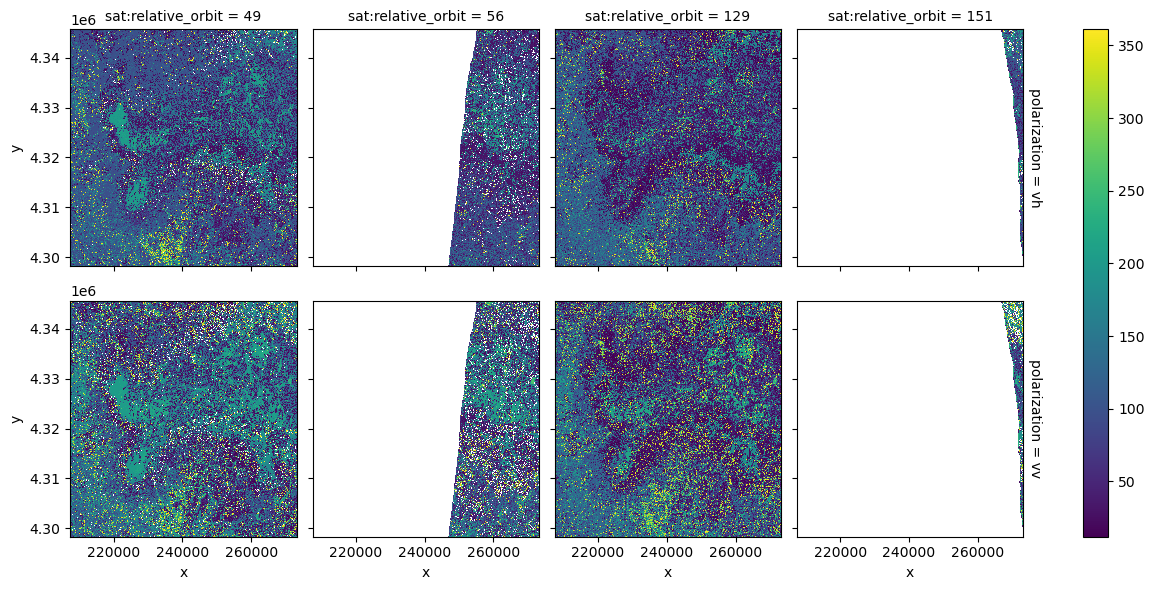

In [14]:
backscatter_minima_DOWY_da.where(lambda x: x > 10).plot.imshow(row='polarization',col='sat:relative_orbit')

In [15]:
backscatter_minima_composite_da = backscatter_minima_DOWY_da.where(lambda x: x > 10).median(dim=["sat:relative_orbit", "polarization"], skipna=True)

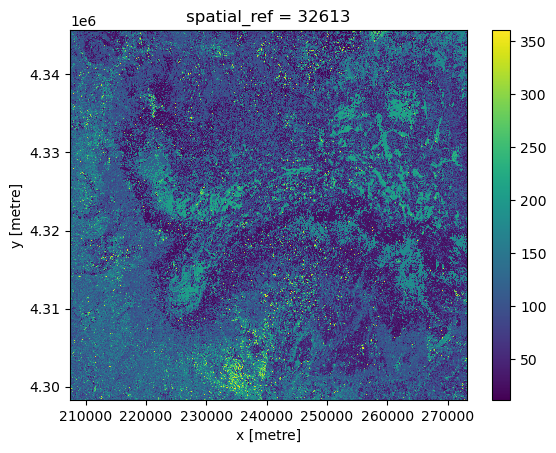

In [16]:
backscatter_minima_composite_da.plot.imshow()

In [17]:
s1 = easysnowdata.remote_sensing.Sentinel1(
    bbox_input=bbox_gdf, start_date="2019-10-01", end_date="2020-09-30", resolution=80, remove_border_noise=False, units='dB'
)

Data searched. Access the returned seach with the .search attribute.
Data retrieved. Access with the .data attribute. Data CRS: WGS 84 / UTM zone 13N.
Metadata retrieved. Access with the .metadata attribute.
Added relative orbit number and orbit state as coordinates to the data.
Linear power units converted to dB. Convert back to linear power units using the .db_to_linear() method.


In [18]:
s1_rtc_ds = s1.data

In [19]:
summer_slice = slice('2020-07-01','2020-08-31')
summer_median_db = s1_rtc_ds.sel(time=summer_slice).groupby('sat:relative_orbit').median(dim=['time'])

In [21]:
ratios = s1_rtc_ds.groupby('sat:relative_orbit') - summer_median_db

In [22]:
binary_wet_snow = xr.where(ratios<-2,1,np.nan)

In [23]:
binary_wet_snow

<xarray.Dataset> Size: 888MB
Dimensions:             (time: 114, y: 592, x: 822)
Coordinates:
  * y                   (y) float64 5kB 4.346e+06 4.346e+06 ... 4.298e+06
  * x                   (x) float64 7kB 2.075e+05 2.076e+05 ... 2.732e+05
    spatial_ref         (time) int32 456B 32613 32613 32613 ... 32613 32613
  * time                (time) datetime64[ns] 912B 2019-10-01T01:09:53.272349...
    sat:orbit_state     (time) object 912B 'ascending' ... 'ascending'
    sat:relative_orbit  (time) int16 228B 49 56 151 129 49 ... 49 56 151 129 49
Data variables:
    vh                  (time, y, x) float64 444MB dask.array<chunksize=(1, 592, 822), meta=np.ndarray>
    vv                  (time, y, x) float64 444MB dask.array<chunksize=(1, 592, 822), meta=np.ndarray>

In [ ]:
# wet_snow_ds = s1_rtc_ds.groupby('sat:relative_orbit') - summer_median_db

In [ ]:
# wet_snow_da = wet_snow_ds.to_dataarray('polarization')
# wet_snow_da